# Overview of Week 3

This week's assignment consists of two parts. The first part gives you an introduction to unsupervised learning. In particular, we focus on techniques for clustering and dimensionality reduction and how they can be applied to ecommerce data. As you work through the three clustering case studies, you will find yourself generating many intermediate datasets, trying different models, and tuning each model as you go along. There's a lot to keep track of.   

This is where Part 2 comes in. It is in Part 2 that we introduce ideas of **workflow management** and **computational reproducibility**. Workflow management means organising your project directory to manage your analysis' artefacts (visualisations, processed datasets, notebooks and utility functions and experiment results). Ideally, your code for these should be clearly commented with well chosen names. Computational reproducibility means someone else (including future you!) being able to take just the code and data, and reproduce your project, from its results and models to visualisations etc. How one decides to practice workflow management and computational reproducibility can be quite a personal decision. Therefore, we provide guidelines, not rules. The most important is having a system rather than no system at all. 

**note about the week**   
While week 1's assignment was guided, with specific instructions about what code to run, as we move on the assignments will involve less hand-holding. For this week, we include some instructions, but leave the specific implementations up to you. There are also many techniques we cover. Again, while we share some resources, we leave the bulk of the research and background reading up to you to manage for yourself. As a record of how well you have synthesised your readings, this notebook has space for writing a few paragraphs of explanations. We hope you won't be content with a shallow explanation, and that you use this space to apply the [Feynmann technique](https://collegeinfogeek.com/feynman-technique/) as a check of understanding. 

To tie Part 1 and Part 2 of the week together, we are not just asking for one Jupyter Notebook as a final deliverable. Instead, there are four deliverables to the week: 

**1. Part 1 Notebook I and II exercises presented at the end of the week job-interview style**

**2. A script that automates the data cleaning and feature engineering steps you take so your findings are reproducible (see Part 2 Notebook I for more info)**

**3. A repo README.md (see Part 2 Notebook I for more info)**

**4  A record of software package versions and software environment used (see Part 2 Notebook I for more info)**   

**recap of the objectives for the first 6 weeks:**  
We aim to broadly cover a wide range of Machine Learning algorithms so that you can: 
- handle the technical demands of a 100E given some guidance on the right direction to take 
- can handle a technical job interview and get hired 

*materials for unsupervised learning adapted from William Thji* 

# Part I : Unsupervised Learning 
Unsupervised Learning refers to a set of machine learning techniques where no output variables (Y) are given. Only the input variables (X) are available and our job is to find patterns in X. You may read more about it from *pg 485 from Hastie and Tibshirani's Elements of Statistical Learning* available [here](https://web.stanford.edu/~hastie/Papers/ESLII.pdf). 

ESL by Hastie et. al with be the primary reference for this week, although feel free to source for your own books and links. 

## Short introduction to clustering 
Clustering puts datapoints into subsets so that datapoints within a cluster are more closely related to one another compared to datapoints in another cluster. More information is available from page 501 of *Elements of Statistical Learning*. 

Some quick points: 
- Clustering is extremely useful to many fields: 
    - Customer segmentation for personalised product recommendations
    - Topic identification to relieve the need to manually vet documents 
    - Image or geo-spatial segmentation to optimised supply and demand (Gojek does this) 
    - and maybe most importantly, getting a sense of the data before starting to model it. 

- Some examples of clustering algorithms: 
    - KMeans
    - Gaussian Mixture Models for drawing soft clustering boundaries instead of hard ones 
    - Hierarchical clustering
    - DBScan for density-based clustering for anomaly detection 
    - Co-clustering
    - Biclustering for analysing genes

## Deliverable 1: Complete the Clustering Case Study: Using PCA and clustering to uncover customer segments 
Context: The dataset we will be working with contains ecommerce transactions from a UK-based online retails store. The dataset is available on [Kaggle](https://www.kaggle.com/carrie1/ecommerce-data/home) or the UCI Machine Learning Repository. The dataset is quite small, so we have also included it inside the `data` folder inside this repo as `data/raw/data.csv`. 

From the Kaggle website: 

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

### Case Study Goal 
Cluster the dataset into meaningful customer segments. This means creating clusters that are statistically robust and that make business sense. 


In [1]:
# %matplotlib qt
# %matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_raw = pd.read_csv('data/raw/data.csv', encoding='ISO-8859-1')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Cleaning data 

Some data types are muddled, there are duplicates, NA values and unreasonable values hiding in the columns 

1. Clean the dataset. You may want to list the steps taken to clean the data and encapsulate the steps inside their own functions so they can be reused. Organise the functions into their own library

<font color='blue'>Deal with negative prices, negative quantities (which are returns maybe)  
Invoice Number: Drop those that start with A, contra against those starting with C.</font>

In [2]:
print(df_raw.info())
print(df_raw.describe())
print(df_raw.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000
InvoiceNo           0
StockCode           0
Description   

In [3]:
def remove_accounting(df):
    print('accounting entries',len(df[df['InvoiceNo'].str.contains('^[A]')]))
    return df[~df['InvoiceNo'].str.contains('^[A]')]

def remove_inventory_management(df):
    # Items with a negative quantity and InvoiceNo not starting with C are removed
    print('inventory adjustment items removed:',len(df_raw[((df_raw['Quantity']<0) & (df_raw['InvoiceNo'].str.contains('^(?!C)')))]))
    return df[~((df['Quantity']<0) & (df['InvoiceNo'].str.contains('^(?!C)')))]

def remove_neg_price(df):
    print('Price at or below 0 removed: ',len(df[df['UnitPrice']<=0]))
    return df[df['UnitPrice']>0]

def remove_ghost_cust(df):
    print('Customers with no ID: ',np.sum(df['CustomerID'].isnull()))
    df.dropna(axis=0,subset=['CustomerID'],inplace=True)
    return df

def remove_neg_quantities(df):
    print('Quantities at or below 0 removed: ',len(df[df['Quantity']<=0]))
    return df[df['Quantity']>0]

def remove_dupe(df):
    print('Duplicates',len(df[df.duplicated(keep='first')]))
    return df.drop_duplicates()

def clean_data(df): # This function calls all the clearning steps
    print('initial len',len(df))
    df = remove_accounting(df)
    df = remove_inventory_management(df)
    df = remove_neg_price(df)
    df = remove_ghost_cust(df)
    df = remove_neg_quantities(df)
    df = remove_dupe(df)
    df.reset_index(inplace=True,drop=True)
    print('final len',len(df))
    return df

df_clean = clean_data(df_raw)

initial len 541909
accounting entries 3
inventory adjustment items removed: 1336
Price at or below 0 removed:  1179
Customers with no ID:  132602
Quantities at or below 0 removed:  8905
Duplicates 5192
final len 392692


In [4]:
# df_clean[df_clean['Quantity']<0]
# df_clean[(df_clean['StockCode']=='22556')&(abs(df_clean['CustomerID']-17548)<0.01)]
# df_clean[df_clean['CustomerID']==12476]

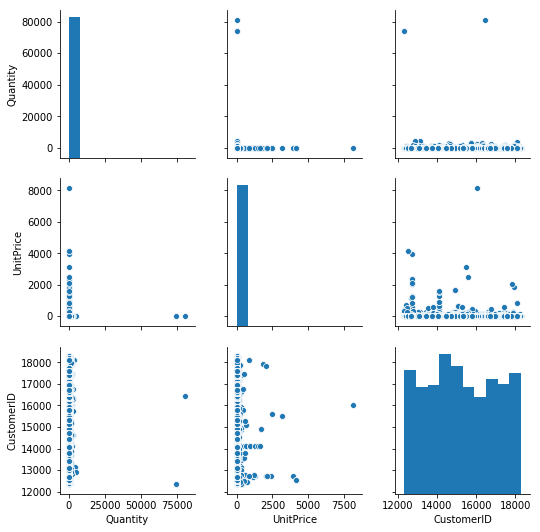

In [7]:
# print(sum(df_raw['Quantity']<0))
# print(sum(df_raw[df_raw['Quantity']<0]['InvoiceNo'].str.contains('^[C]')))
# print(sum(df_raw[df_raw['Quantity']<0]['InvoiceNo'].str.contains('^(?!C)')))
# df_raw[~((df_raw['Quantity']<0) & (df_raw['InvoiceNo'].str.contains('^(?!C)')))]

sns.pairplot(df_clean[['Quantity','UnitPrice','CustomerID']])

### Feature Engineering iteration #1 

Inside the dataset, each row contains information about an ecommerce transation. However, we want to cluster the data by customers, which means each row should instead contain information about a customer. 

1. Reshape the data to follow the format below: 
![alt text](customer.png)

The dataframe should have these columns: `['NoOfInvoices', 'NoOfUniqueItems', 'QuantityPerInvoice', 'TotalQuantity', 'UniqueItemsPerInvoice','UnitPriceMean','UnitPriceStd']` 
2. Save this dataset as an intermediate dataset 

In [6]:
df_clean.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [8]:
## your code here 
def engineer_features1(df):
    grouped = df.groupby('CustomerID')
    NoOfInvoices = grouped['InvoiceNo'].nunique()
    NoOfUniqueItems = grouped['StockCode'].nunique()
    QuantityPerInvoice = grouped['Quantity'].sum()/NoOfInvoices
    TotalQuantity = grouped['Quantity'].sum()
    UniqueItemsPerInvoice = NoOfUniqueItems/NoOfInvoices
    UnitPriceMean = grouped['UnitPrice'].mean()
    UnitPriceStd = grouped['UnitPrice'].std()
    UnitPriceStd.fillna(0,inplace=True)
    df_new = pd.DataFrame({'NoOfInvoices':NoOfInvoices,'NoOfUniqueItems':NoOfUniqueItems,'QuantityPerInvoice':QuantityPerInvoice,\
                          'TotalQuantity':TotalQuantity,'UniqueItemsPerInvoice':UniqueItemsPerInvoice,\
                           'UnitPriceMean':UnitPriceMean,'UnitPriceStd':UnitPriceStd})
    df_new.index = df_new.index.astype(int)
    return df_new

df_new = engineer_features1(df_clean)
df_new.to_pickle('./data/engineered_df.pkl')

### Hierarchical clustering iteration #1 [reference pg 520](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)

1. Implement any more preprocessing or visualisation steps you feel are necessary to understand how you might build meaningful clusters from the data. 
2. Apply hierarchical clustering to the dataset. 
2. Experiment with different linkage algorithms. Visualise the resulting trees for average linkage, complete linkage and single linkage side-by-side. Which linkage algorithm works best? 
3. List two ways to improve the clustering and implement at least one. Track the results of the first iteration and second iteration (whether with Excel, TextEdit or within this notebook itself). 
4. Describe the clusters you selected and evaluate whether or not they form meaningful segments. 

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import axes3d
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabaz_score#, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
df_clus = pd.read_pickle('./data/engineered_df.pkl')

'''Prep data here'''
# features = [ 'NoOfUniqueItems', 'TotalQuantity','UnitPriceMean','UnitPriceStd']
features = df_clus.columns
X = df_clus[features]
labelList = X.index
X = StandardScaler().fit_transform(X)
# X = normalize(X)

df_inlier = df_clus[(df_clus['NoOfInvoices']<=5)&(df_clus['NoOfUniqueItems']<=77)&(df_clus['QuantityPerInvoice']<=270)& \
                   (df_clus['TotalQuantity']<=989.75)&(df_clus['UniqueItemsPerInvoice']<=24) & \
                   (df_clus['UnitPriceMean']<=3.8325) & (df_clus['UnitPriceStd']<=3.55)]
# features = [ 'NoOfUniqueItems', 'TotalQuantity','UnitPriceMean','UnitPriceStd']
features_X2 = df_inlier.columns
X2 = df_inlier[features_X2]
labelList_X2 = X2.index
X2 = StandardScaler().fit_transform(X2)


def make_figure(X,labels,axii=[0,1,2],rotate=False):
    fig = plt.figure(figsize=(10, 7))  
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,axii[0]], X[:,axii[1]], X[:,axii[2]], c=labels, cmap='rainbow',alpha=0.7)
    ax.set_xlabel(features[axii[0]])
    ax.set_ylabel(features[axii[1]])
    ax.set_zlabel(features[axii[2]])
    if rotate:
    # rotate the axes and update
        for angle in range(0, 360):
            ax.view_init(30, angle)
            plt.draw()
            plt.pause(.001)

def make_dendogram(X):
    linked = linkage(X, 'single')
    plt.figure(figsize=(10, 7))  
    dendrogram(linked,  
                orientation='top',
                labels=labelList,
                distance_sort='descending',
                show_leaf_counts=True)
    plt.show()  
    
def make_clustering(X,nclusters):
    cluster = AgglomerativeClustering(n_clusters=nclusters, affinity='euclidean', linkage='ward')  
    cluster.fit_predict(X) 
    make_figure(X,cluster.labels_)
    
    return cluster

    


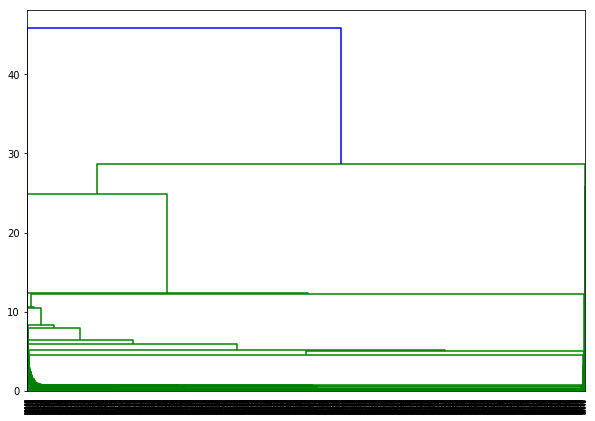

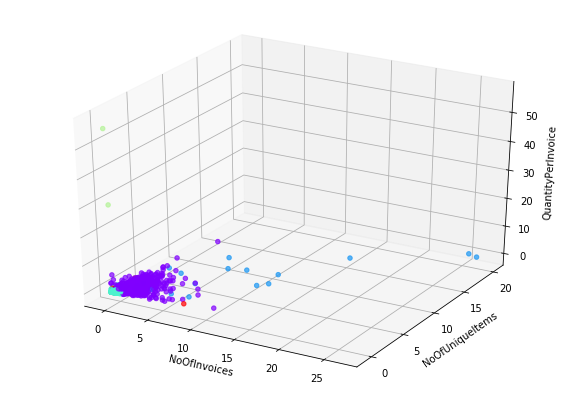

In [18]:
make_dendogram(X)
cluster = make_clustering(X,6)

In [3]:
np.shape(cluster.children_)

(4337, 2)

### K-means and GMM Clustering iteration #1 [reference pg 509](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)
Apart from hierarchical clustering, we can also apply KMeans and Gaussian Mixture Models (GMM) on the data

1. Implement K-means clustering on the data, experimenting with different values of k 
2. Implement a Gaussian Mixture Model on the data, experimenting with different values for the number of components.  
3. Visualise how well K-means and GMMs succeed at separating subgroups in the data
4. List two ways to improve the clustering and implement at least one. 
5. Describe the clusters and evaluate whether or not they form meaningful segments. 

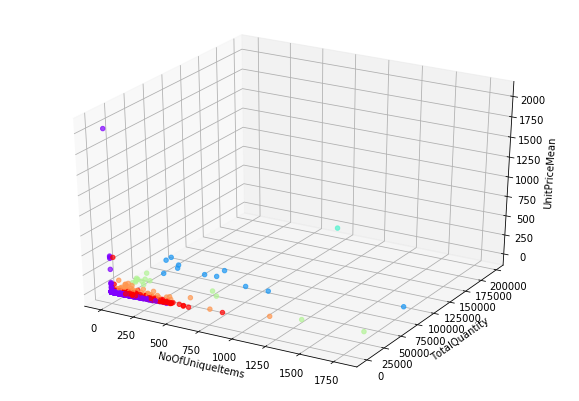

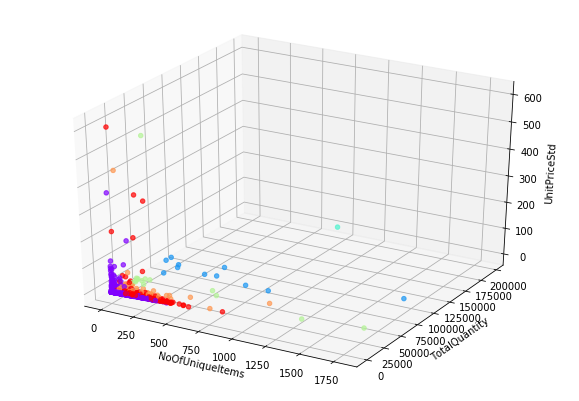

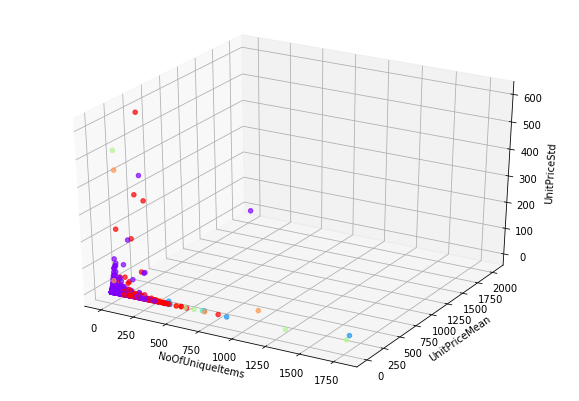

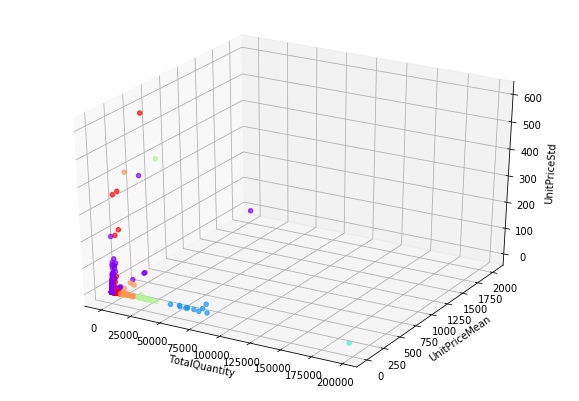

In [7]:
   
def do_kmeans(X):
    kmeans = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, \
       tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, \
                    copy_x=True, n_jobs=None, algorithm='auto')
    kmeans.fit_predict(X)
    make_figure(X,kmeans.labels_,axii=[0,1,2])
    make_figure(X,kmeans.labels_,axii=[0,1,3])
    make_figure(X,kmeans.labels_,axii=[0,2,3])
    make_figure(X,kmeans.labels_,axii=[1,2,3])
    
do_kmeans(X.values)

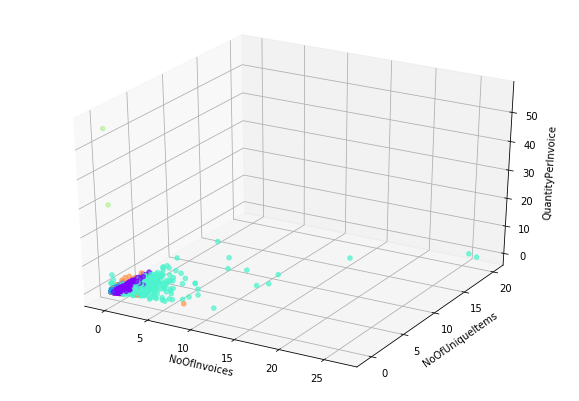

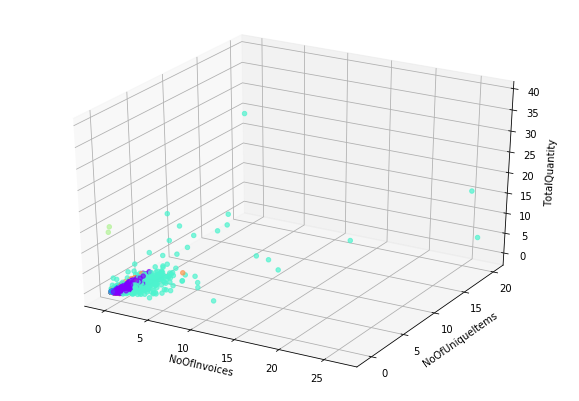

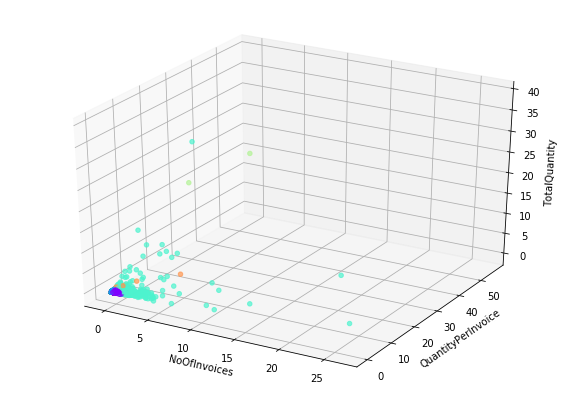

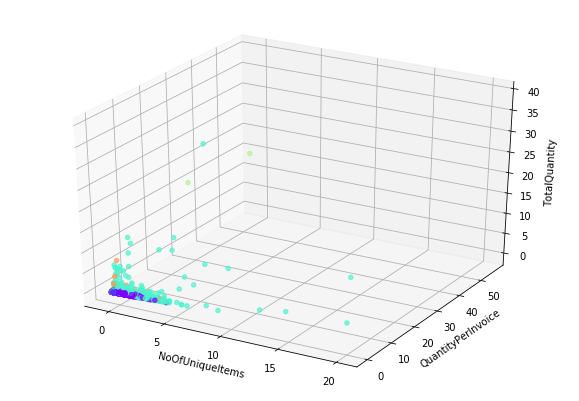

In [66]:
def do_gmm(X):
    gmm = GaussianMixture(n_components=6, covariance_type='full', tol=0.001, reg_covar=1e-06, \
                          max_iter=100, n_init=1, init_params='kmeans', weights_init=None, \
                          means_init=None, precisions_init=None, random_state=None, warm_start=False, \
                          verbose=0, verbose_interval=10)
    gmm.fit(X)
    something = gmm.predict(X)
    make_figure(X,something,axii=[0,1,2])
    make_figure(X,something,axii=[0,1,3])
    make_figure(X,something,axii=[0,2,3])
    make_figure(X,something,axii=[1,2,3])
    return gmm
    
gmm = do_gmm(X)

### Outliers 

1. Do outliers influence the results of your Hierarchical Clustering, K-means and GMM models?  
2. Do the outliers themselves form clusters? 

       NoOfInvoices  NoOfUniqueItems  QuantityPerInvoice  TotalQuantity  \
count   4338.000000      4338.000000         4338.000000    4338.000000   
mean       4.272015        61.501153          252.462892    1187.644537   
std        7.697998        85.366768         1312.769337    5043.619654   
min        1.000000         1.000000            1.000000       1.000000   
25%        1.000000        16.000000           92.000000     159.000000   
50%        2.000000        35.000000          161.000000     378.000000   
75%        5.000000        77.000000          270.000000     989.750000   
max      209.000000      1787.000000        74215.000000  196915.000000   

       UniqueItemsPerInvoice  UnitPriceMean  UnitPriceStd  
count            4338.000000    4338.000000   4338.000000  
mean               18.693001       4.470820      4.328742  
std                17.166093      34.215024     18.785884  
min                 0.200000       0.122500      0.000000  
25%                 8.00

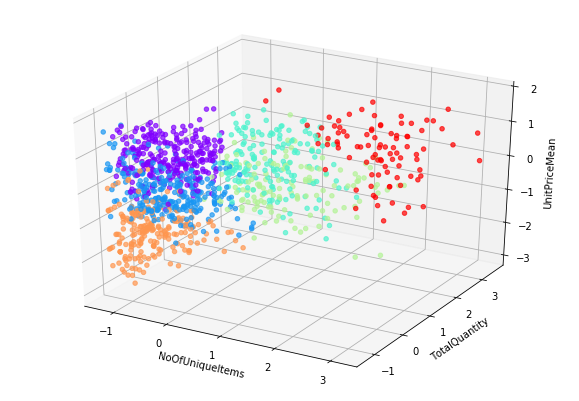

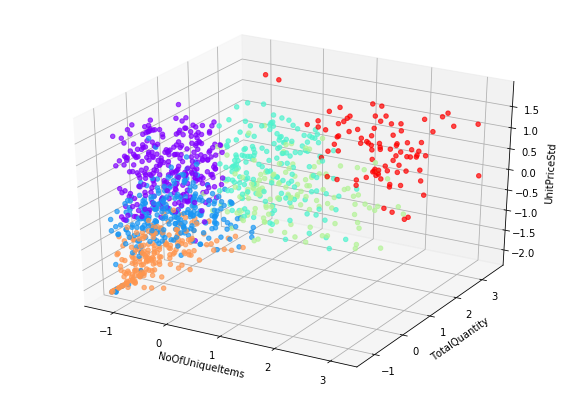

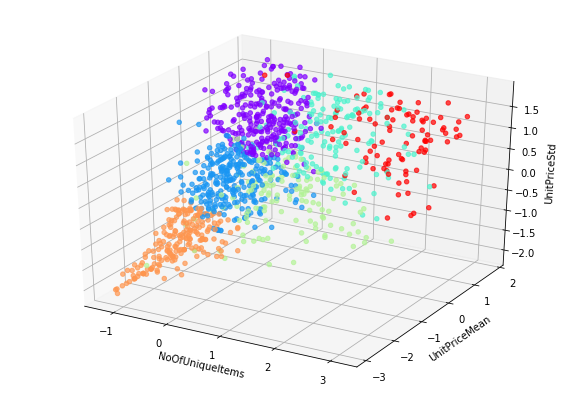

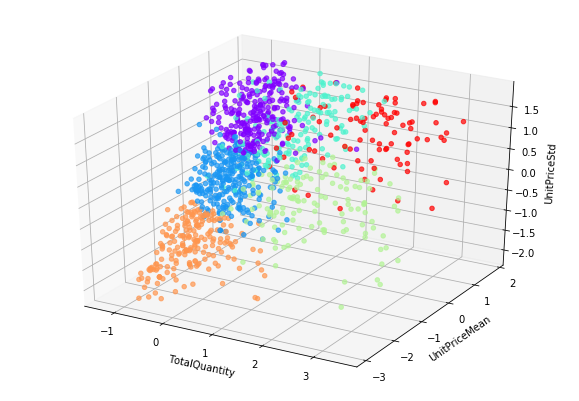

In [9]:


do_kmeans(X2)

### Validating clusters  

1. Use at least three techniques to validate that your chosen clusters correspond to meaningful customer segments. You may consider a combination of using visualisations and/or quantitative metrics (refer to Elements of Statistical Learning for some examples)

<font color='blue'>
    <strong>Methods for validating clusters (quantitative metrics):</strong>
    <ol>
        <li>silhouette_score</li>
        <li>calinski_harabaz_score</li>
        <li>davies_bouldin_score</li>
    </ol>
    <strong> visualizations/qualitative metrics </strong>
    <ol>
        <li>dimensionality reduction (sklearn.manifold.TSNE, sklearn.decomposition.PCA)</li>
        <li>plot in 3d space</li>
        <li>groupby classes and inspect features</li>
    </ol>
    <strong>Process</strong><br>
    For now, use data with outliers removed. Data can be processed using standardscaler. Fix 3 categories<br>
    Train with hierarchical, Kmeans, and GMM.<br>
    For each model, print scores, plot in 2D space, groupby and plot distributions of each variable.
</font>

Silhouette score: 0.2108, Calinsky harabaz score: 367.9159


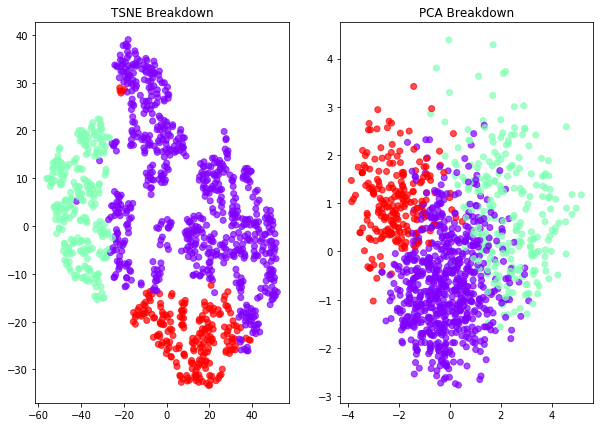

C:\Users\likkhian\Anaconda3\lib\site-packages\ipykernel\__main__.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\likkhian\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


        NoOfInvoices  NoOfUniqueItems  QuantityPerInvoice  TotalQuantity  \
labels                                                                     
0           1.664688        18.798220          125.728981     196.522255   
1           3.713710        45.927419          153.421774     561.197581   
2           1.459091         7.109091          102.164394     143.236364   

        UniqueItemsPerInvoice  UnitPriceMean  UnitPriceStd  
labels                                                      
0                   12.330168       2.723223      2.178241  
1                   12.774395       2.635123      2.257950  
2                    5.102652       1.644087      0.668360  


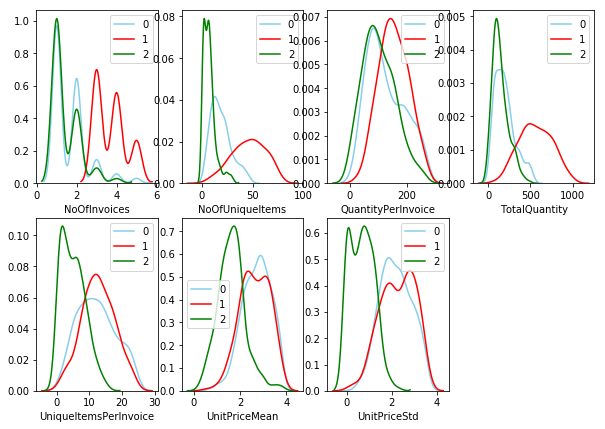

Silhouette score: 0.2456, Calinsky harabaz score: 450.7798


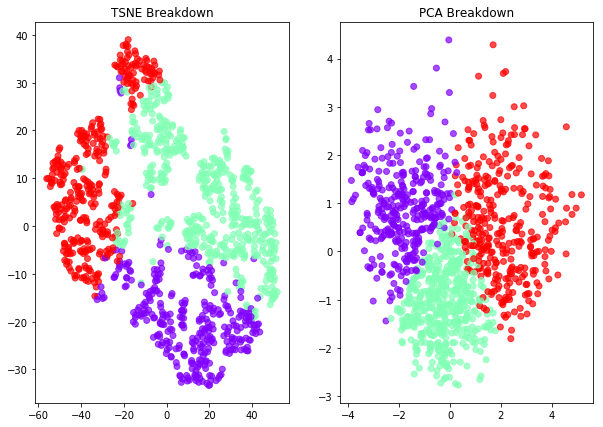

        NoOfInvoices  NoOfUniqueItems  QuantityPerInvoice  TotalQuantity  \
labels                                                                     
0           1.592705         8.759878          107.935309     162.632219   
1           1.473573        17.378436          115.733087     156.828753   
2           3.361765        42.711765          161.804804     516.055882   

        UniqueItemsPerInvoice  UnitPriceMean  UnitPriceStd  
labels                                                      
0                    6.189108       1.745955      0.874939  
1                   12.641085       2.897383      2.330391  
2                   13.487402       2.664060      2.308868  


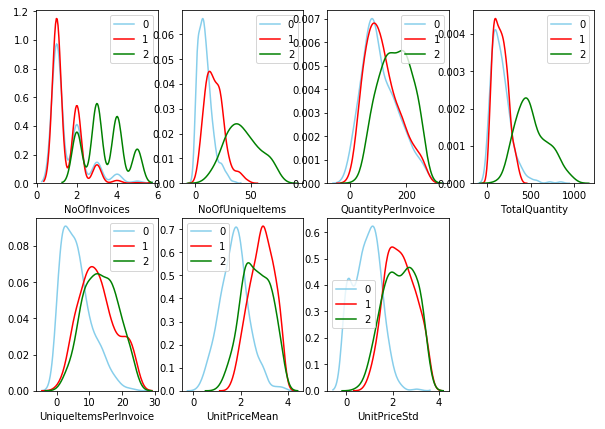

Silhouette score: 0.0937, Calinsky harabaz score: 214.8495


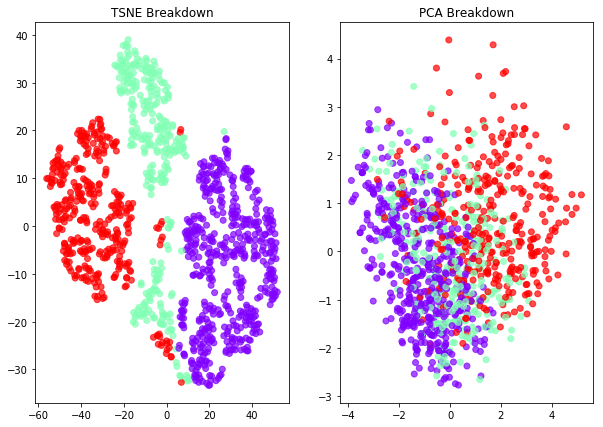

        NoOfInvoices  NoOfUniqueItems  QuantityPerInvoice  TotalQuantity  \
labels                                                                     
0               1.00        11.058704          124.091093     124.091093   
1               2.00        22.708054          128.367450     256.734899   
2               3.64        38.268571          130.604571     472.391429   

        UniqueItemsPerInvoice  UnitPriceMean  UnitPriceStd  
labels                                                      
0                   11.058704       2.373343      1.666731  
1                   11.354027       2.524500      2.022768  
2                   10.727619       2.645513      2.139986  


C:\Users\likkhian\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\likkhian\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\likkhian\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


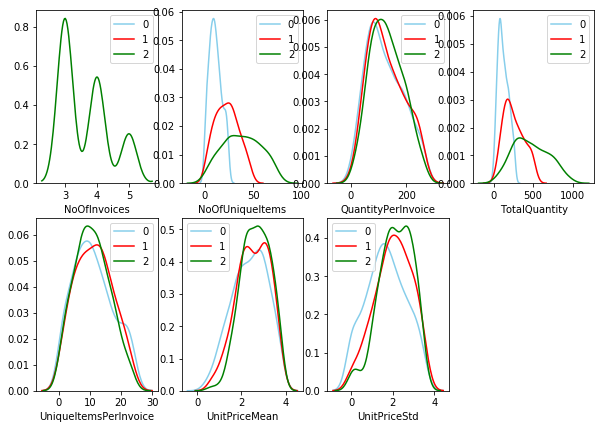

In [47]:
nclusters = 3
#define models
models = [AgglomerativeClustering(n_clusters=nclusters, affinity='euclidean', linkage='ward') ,\
          KMeans(n_clusters=nclusters, init='k-means++', n_init=10, max_iter=300, \
               tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, \
                copy_x=True, n_jobs=None, algorithm='auto'), \
          GaussianMixture(n_components=nclusters, covariance_type='full') ]

def make_figure_lowd(X,labels,fig,axii=[0,1,2]):
    X_low = TSNE(n_components=2,random_state=42).fit_transform(X)
    ax = fig.add_subplot(121)
    ax.scatter(X_low[:,0], X_low[:,1], c=labels, cmap='rainbow',alpha=0.7)
    ax.set_title('TSNE Breakdown')
#     plt.colorbar()
    X_low2 = PCA(n_components=2).fit_transform(X)
    ax2 = fig.add_subplot(122)
    ax2.scatter(X_low2[:,0], X_low2[:,1], c=labels, cmap='rainbow',alpha=0.7)
    ax2.set_title('PCA Breakdown')
#     plt.colorbar()

def make_clustering2(X,nclusters):
    model = GaussianMixture(n_components=nclusters, covariance_type='full')  
    model.fit(X)
    dis = model.predict(X)
    return dis #model

def make_kde(df,fig_ct):
    plt.figure(fig_ct,figsize=(10, 7))
    columnss = df.columns
    for jj, coll in enumerate(columnss[:-1]):
    
        plt.subplot(2,4,jj+1)
        sns.distplot( df[df['labels']==0][coll] , color="skyblue", label='0',hist=False)
        sns.distplot( df[df['labels']==1][coll] , color="red", label='1',hist=False)
        sns.distplot( df[df['labels']==2][coll] , color="green", label='2',hist=False)
    plt.show()
    fig_ct += 1
    return fig_ct

def compare_models(models,x_vals,df):
    fig_ct=1
    for ii,model in enumerate(models):
        if ii<2:
            model.fit_predict(x_vals)
            labels = model.labels_
        else: #GMM model is special
            model.fit(x_vals)
            labels = model.predict(x_vals)
        #calculate objective scores
        silh_score = silhouette_score(x_vals, labels, metric='euclidean')
        calinsky_score = calinski_harabaz_score(x_vals, labels)
        print('Silhouette score: {:.4f}, Calinsky harabaz score: {:.4f}'.format(silh_score,calinsky_score))
        # Make lower dimension plots
        fig = plt.figure(fig_ct,figsize=(10, 7)) 
        make_figure_lowd(x_vals,labels,fig)
        plt.show()
        fig_ct+=1
        # Inspect
        df['labels'] = labels
        print(df.groupby('labels').mean())
        make_kde(df,fig_ct)
    
compare_models(models,X2,df_inlier)
    



### Model selection

1. Explain when it is appropriate to use K-Means, GMM and Hierarchical Clustering 
2. Which model would you choose for this dataset? 

<font color='blue'>
How to choose the number of clusters?  <br>
Hierarchical clustering: Draw horizontal line from the longest vertical based on dendogram.  <br>
K-Means: Elbo method <br>
GMM: AIC, BIC <br>
Validating the model:  <br>
silhouette score, dimensionality reduction, back-comparing members of a category <br>
    https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
</font>

### Opening the black box of clustering [reference pg 503](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)

1. In your own words, explain the broad idea behind building a proximity matrix to cluster data. (This should also be verbally presented during Monday's presentation). 
*Sometimes, typing values into MS Excel helps with building intuition

<font color='blue'>A proximity matrix is a matrix of NxN where N is the number of datapoints. Each element $x_{ij}$ is the distance between $i^{th}$ and $j^{th}$ element. In clustering, we aim to find the points that have the most in common to be grouped into a particular cluster. The $i^{th}$ and $j^{th}$ elements in the proximity matrix with the smallest value of $x_{ij}$ are thus the two closest points and should belong in the same cluster.
</font>

2. In your own words, how would you calculate the disimilarity between objects in a dataset? (This should also be verbally presented during Monday's presentation)

<font color='blue'>
    Dissimilarity between objects are calculated by the distance between each object. The distance may vary depending on the distance metric.
    <ol>
        <li>Hamming</li>
        <li>Euclidean</li>
        <li>Manhatten</li>
        <li>MahalanobisDistance</li>
        <li>MinkowskiDistance (generalized distance)</li>
    </ol>
    In addition, the dissimilarity can be based on
    <ol>
        <li>the distance between the 2 nearest points in each cluster</li>
        <li>between the 2 furthest points</li>
        <li>between the 2 centroids</li>
        <li>average of all the points in one cluster and all the points in the other cluster</li>
    </ol>
</font>

### PCA for Dimensionality Reduction 

1. Using the dataset that you have pre-processed, construct a pairplot again. How is it different from the a plot of the raw data and what is your interpretation?  
2. Apply PCA pre-processed dataset. More information on PCA here [link]
3. Create a plot of cumulative explained variance and number of components. How does this inform you about the best number of components to select? 
4. Create a plot of PC0 against PC1, coloured by the GMM's predictions on the normalised dataset with outliers removed for n_components =7
5. How do the values of principal components relate to the original dataset

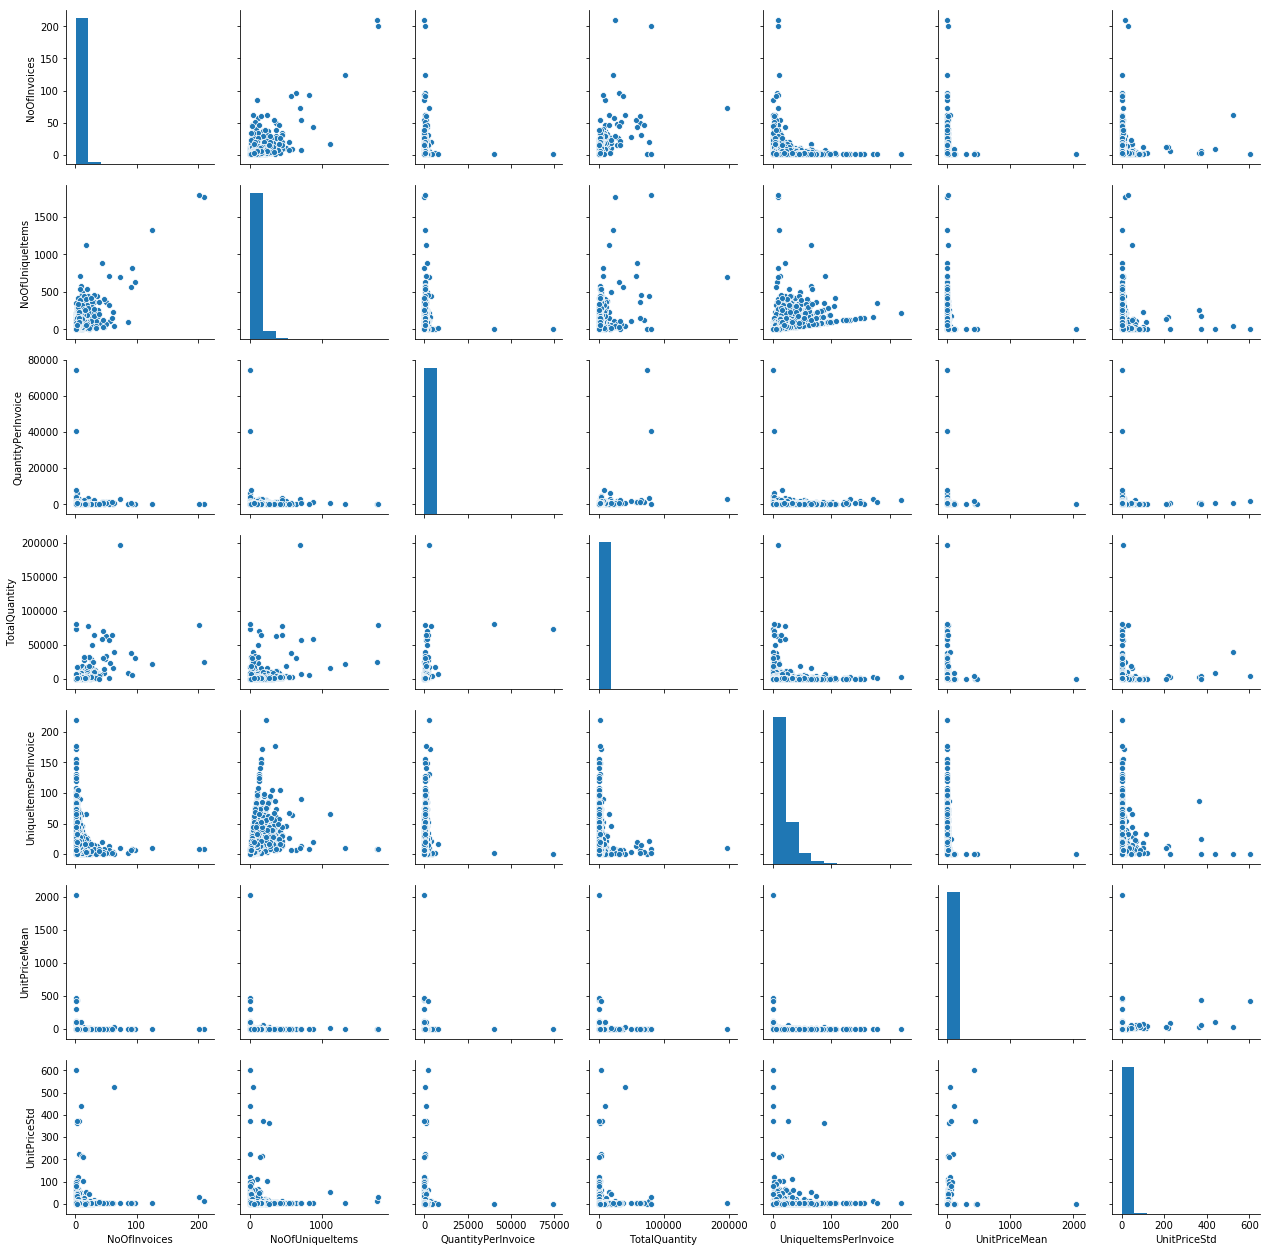

In [22]:
from sklearn.decomposition import PCA
sns.pairplot(df_clus)
'''
1. We are able to see more features, and some fairly correlated ones too.
'''

[0.44349659]
[0.44349659 0.22632422]
[0.44349659 0.22632422 0.18605863]
[0.44349659 0.22632422 0.18605863 0.09242093]
[0.44349659 0.22632422 0.18605863 0.09242093 0.03526954]
[0.44349659 0.22632422 0.18605863 0.09242093 0.03526954 0.00960082]


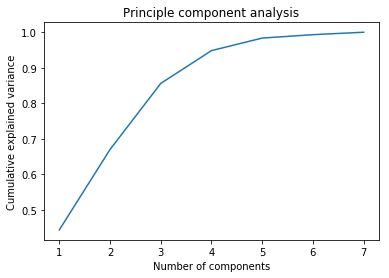

In [88]:
def pca_test(X):
    pca = PCA(n_components=7).fit(X)
    vvarr = pca.explained_variance_ratio_
    vvarr_cum = np.cumsum(vvarr)
    plt.plot(np.arange(1,8),vvarr_cum)
    plt.title('Principle component analysis')
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    return pca
pca = pca_test(X2)
# pca_test(df_inlier)
for i in range(0,6):
    pca=PCA(n_components=i+1).fit(X2)
    vvarr=pca.explained_variance_ratio_
    print(vvarr)

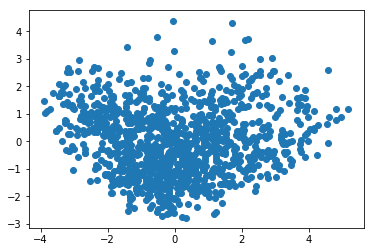

In [89]:
pc0=pca.components_[0]
pc1=pca.components_[1]
array0 = np.dot(X2,pc0)
array1 = np.dot(X2,pc1)
plt.scatter(array0,array1)

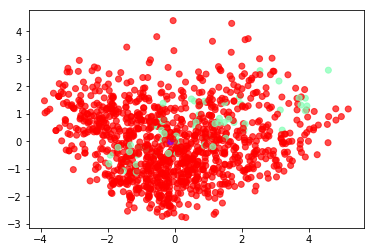

In [90]:
something = gmm.predict(X2)

bb=pca.transform(X2)
plt.scatter(bb[:,0],bb[:,1],c=something, cmap='rainbow',alpha=0.7)

# np.shape(bb)
# np.unique(something)